Draft

In [1]:
#!pip install torch==1.11
import torch as th 
import torchvision
import numpy as np 
from torch.autograd import Variable
import matplotlib.pyplot as plt 
from torchvision import datasets, transforms
DATA_DIR = "./"
train_ds = torchvision.datasets.MNIST(DATA_DIR, download=True,train=True, transform=transforms.ToTensor())
test_ds = torchvision.datasets.MNIST(DATA_DIR, download=True,train=False, transform=transforms.ToTensor())

#preprocessing = transforms.Compose([transforms.ToTensor(),
                                   #transforms.Normalize(ds_mean, ds_var**0.5)
#                                   ])
# 
#train_ds = torchvision.datasets.MNIST(DATA_DIR, download=True,train=True, transform=preprocessing)
#test_ds = torchvision.datasets.MNIST(DATA_DIR, download=True,train=False, transform=preprocessing)


#x_train = train_ds.data.view(-1, 784) / 255. 
#y_train = train_ds.targets + 1 
#x_test = test_ds.data.view(-1, 784) / 255.
#y_test = test_ds.targets  + 1 
dim = 784 
K = 10 
D = dim*K + 1 # 1 for lambda 

from torch import linalg as LA
device = th.device("cuda" if th.cuda.is_available() else "cpu")
#x_test = x_test.to(device)
#y_test = y_test.to(device)
#x_train = x_train.to(device)
#y_train = y_train.to(device)
S = 100
bsz = 4096
trainloader = th.utils.data.DataLoader(train_ds, batch_size=S, shuffle=True)
testloader = th.utils.data.DataLoader(test_ds, batch_size=10000, shuffle=True)
total_steps = len(trainloader)
#llimit = 1 
N = len(train_ds)
# 
#mean = (train_ds.data / 255.).mean(0).view(-1).to(device)
#scale = (train_ds.data/255.).std(0).view(-1).to(device) + 1e-7 

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



/opt/conda/lib/python3.7/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /usr/local/src/pytorch/torch/csrc/utils/tensor_numpy.cpp:174.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [2]:
def loss_(dim=784, K=10):
  def loss(x, y, param):
    theta, _ = th.split(param, [dim*K, 1])
    theta = theta.view(dim, K)
    lambd = th.tensor(1e-1)
    return (lambd / 2)*th.sum(th.square(theta)) - dim*K*th.log(lambd)/2  +  (1)*(th.sum(th.logsumexp(x @ theta, 1)) -th.trace(x @ theta[:, y])) #+ dim*K*np.log(2*np.pi)/2
    #th.sum(th.log(th.sum(th.exp(x @ theta), dim=-1))) - th.trace(x @ theta[:, y -1])
  return loss

In [3]:
criterion = loss_()
@th.no_grad()
def validate(testloader, param):
  total_loss = 0.
  for (data, target) in testloader:
        # putting data on device 
        data = data.to(device).view(-1, 784)
        target = target.to(device).view(-1)
        loss = criterion(data, target, param)
        total_loss += loss.item()
  return total_loss 

In [4]:
w = th.empty((D,1), device=device)
w = th.nn.init.xavier_uniform_(w)
param = Variable(w.view(-1), requires_grad=True)

In [5]:
losses = []
val_losses = []
epochs = 50
log_freq = 2 
B = 3*th.eye(D)
B[-1,-1] = 0 # lambda is fixed 
C = B@B.T
eps = 2*D*S / N / th.trace(C) # eq17
H = 2*S/eps/N/C.diag() # eq19
H = th.diag(H).to(device)
optimizer  = th.optim.SGD([param], lr=eps)
eps

tensor(0.0004)

In [6]:
for e in range(epochs):
  # compute loss 
  for i, (data, target) in enumerate(trainloader):
        # putting data on device 
        data = data.to(device).view(-1, 784) #- mean 
        #data = data / scale
        target = target.to(device).view(-1)
        # making mini batch 
        idx = np.random.choice(data.size(0), S) #TODO cas mbsz >= data.size(0)
        #theta.grad.data.zero_()
        #loglambd.grad.data.zero_()
        loss = criterion(data, target, param)
        # back prop 
        optimizer.zero_grad()
        loss.backward()
        #print(theta.grad[0])
        param = Variable(param.detach() - eps*H@param.grad.data, requires_grad=True) 
        #loglambd = loglambd.detach() - eps*loglambd.grad.data
        #loglambd.requires_grad = True 
        #print(theta)
        #optimizer.step()
        if i% (total_steps//log_freq) ==0:
          val_loss =  validate(testloader, param)
          print(f"Epoch:{e+1:3d}/{epochs} step {i+1:3d} / {total_steps} loss: {loss.item():9.2f} validation loss : #{val_loss:9.2f}") 
          losses.append(loss.item())
          val_losses.append(val_loss)

Epoch:  1/50 step   1 / 600 loss:   9262.89 validation loss : # 32211.04
Epoch:  1/50 step 301 / 600 loss:   9074.18 validation loss : # 14724.20
Epoch:  2/50 step   1 / 600 loss:   9084.22 validation loss : # 13618.96
Epoch:  2/50 step 301 / 600 loss:   9071.90 validation loss : # 13209.97
Epoch:  3/50 step   1 / 600 loss:   9056.76 validation loss : # 12936.23
Epoch:  3/50 step 301 / 600 loss:   9067.03 validation loss : # 12772.36
Epoch:  4/50 step   1 / 600 loss:   9067.64 validation loss : # 12658.82
Epoch:  4/50 step 301 / 600 loss:   9060.62 validation loss : # 12571.23
Epoch:  5/50 step   1 / 600 loss:   9058.38 validation loss : # 12504.63
Epoch:  5/50 step 301 / 600 loss:   9056.61 validation loss : # 12439.89
Epoch:  6/50 step   1 / 600 loss:   9063.49 validation loss : # 12406.59
Epoch:  6/50 step 301 / 600 loss:   9081.76 validation loss : # 12364.24
Epoch:  7/50 step   1 / 600 loss:   9053.18 validation loss : # 12327.36
Epoch:  7/50 step 301 / 600 loss:   9058.46 validat

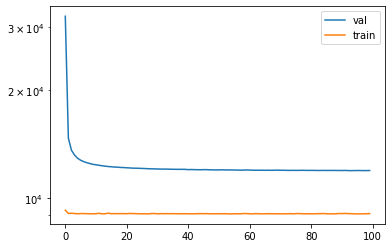

In [7]:
plt.semilogy(val_losses, label="val")
plt.semilogy(losses, label="train")
plt.legend()